In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pathlib import Path
import matplotlib.pyplot as plt
from jinja2 import Template
from textwrap import dedent
from datetime import datetime



In [2]:
EOD_FILE   = "eod.csv"
EODDE_FILE = "eodde.csv"
INDEX_FILE = "AIndexEODPrices.csv"
IND_FILE   = "AShareIndustriesClassCITICS.csv"

INDEX_CODE = "000906.SH"   
START_DATE = "2023-12-29" 
N_GROUPS   = 10        
IMG1 = "cum_returns.png"
IMG2 = "excess_returns.png"
REPORT_HTML = "factor_report.html"   

In [3]:
# 读取数据
eod   = pd.read_csv(EOD_FILE,   parse_dates=["trade_dt"],encoding='gbk')
eodde = pd.read_csv(EODDE_FILE, parse_dates=["trade_dt"])
index_df = pd.read_csv(INDEX_FILE, parse_dates=["trade_dt"])

industry = (pd.read_csv(IND_FILE,encoding='gbk')
              .query("cur_sign == 1")
              [["s_info_windcode", "industriescode"]]
              .drop_duplicates("s_info_windcode"))

trade_days = eod["trade_dt"].drop_duplicates()
eodde = eodde[eodde["trade_dt"].isin(trade_days)]

In [4]:
def winsorize_series(x: pd.Series, lower=0.05, upper=0.95):
    return x.clip(lower=x.quantile(lower), upper=x.quantile(upper))


def zscore(x: pd.Series):
    return (x - x.mean()) / x.std(ddof=0)


def neutralize(factor: pd.Series,
               mv: pd.Series,
               industry: pd.Series):

    mv_num = pd.to_numeric(mv, errors="coerce")
    log_mv = np.log(mv_num)

    ind_dummies = (pd.get_dummies(industry, prefix="ind")
                     .astype("float32"))

    df = (pd.DataFrame({"factor": factor, "mv": log_mv})
            .join(ind_dummies)
            .dropna())

    y = df["factor"].astype("float64")                
    X = sm.add_constant(df.drop(columns="factor")     
                          .astype("float64"))

    return sm.OLS(y, X).fit().resid


In [5]:
def compute_factor_pipeline(eodde: pd.DataFrame,
                            industry: pd.DataFrame) -> pd.DataFrame:

    eodde = eodde.copy()
    eodde["EP_raw"] = 1 / eodde["s_val_pe_ttm"].replace({0: np.nan})
    eodde.loc[np.isinf(eodde["EP_raw"]), "EP_raw"] = np.nan
    eodde["month"] = eodde["trade_dt"].dt.to_period("M")

    all_factor_rows = []
    for m, grp in eodde.groupby("month"):
        last_day = grp["trade_dt"].max()
        slice_ = grp.loc[grp["trade_dt"] == last_day,
                         ["s_info_windcode", "EP_raw", "s_val_mv"]]

        slice_ = slice_.merge(industry[["s_info_windcode", "industriescode"]],
                              on="s_info_windcode", how="left")

        ep = slice_.set_index("s_info_windcode")["EP_raw"]
        ep = winsorize_series(ep)
        ep = zscore(ep)
        resid = neutralize(ep,
                           mv=slice_.set_index("s_info_windcode")["s_val_mv"],
                           industry=slice_.set_index("s_info_windcode")["industriescode"])
        all_factor_rows.append(pd.DataFrame({
            "trade_dt": last_day,
            "s_info_windcode": resid.index,
            "factor": resid.values
        }))

    return pd.concat(all_factor_rows, ignore_index=True)


In [6]:
factor_df = compute_factor_pipeline(eodde, industry)

In [7]:
def build_quantile_groups(factor_df: pd.DataFrame,
                          n_groups: int = 10,
                          start: str = "2023-12-29") -> pd.DataFrame:
    
    factor_df = factor_df[factor_df["trade_dt"] >= pd.to_datetime(start)]
    out = []
    for dt, frame in factor_df.groupby("trade_dt"):
        quantiles = pd.qcut(frame["factor"], n_groups,
                            labels=False, duplicates="drop")
        out.append(frame.assign(group=quantiles)[
            ["trade_dt", "s_info_windcode", "group"]])
    return pd.concat(out, ignore_index=True)



In [8]:
assign_df = build_quantile_groups(factor_df,
                                  n_groups=N_GROUPS,
                                  start=START_DATE)

In [9]:
def calc_stock_daily_returns(eod: pd.DataFrame, 
                             start: str = "2023-12-31") -> pd.DataFrame:
    
    eod = eod.sort_values(["s_info_windcode", "trade_dt"])
    eod['adj_close']= eod['s_dq_close']* eod['s_dq_adjfactor']
    eod["ret"] = eod.groupby("s_info_windcode")["adj_close"].pct_change()
    eod = eod[eod["trade_dt"] >= pd.to_datetime(start)]
    return eod[["trade_dt", "s_info_windcode", "ret"]].dropna()

In [10]:
stock_ret = calc_stock_daily_returns(eod,start=START_DATE)

In [11]:
def generate_portfolio_returns(stock_ret: pd.DataFrame,
                               assignments: pd.DataFrame,
                               n_groups: int = 10) -> pd.DataFrame:

    dates = stock_ret["trade_dt"].sort_values().unique()
    group_ret = pd.DataFrame(index=dates,
                             columns=[f"Q{i+1}" for i in range(n_groups)],
                             dtype=float)

    ret_wide = stock_ret.pivot(index="trade_dt",
                               columns="s_info_windcode", values="ret")
    rebalance_dates = assignments["trade_dt"].unique()

    current_w = {g: pd.Series(dtype=float) for g in range(n_groups)}
    for d in dates:
        if d in rebalance_dates:          # 月末的 next-day（即月初）触发权重重设
            ass = assignments[assignments["trade_dt"] == d]
            for g in range(n_groups):
                stocks = ass.loc[ass["group"] == g, "s_info_windcode"]
                current_w[g] = pd.Series(1/len(stocks), index=stocks) if len(stocks) else pd.Series(dtype=float)


        daily_r = ret_wide.loc[d].fillna(0)
        for g in range(n_groups):
            w = current_w[g]
            if w.empty:
                group_ret.loc[d, f"Q{g+1}"] = np.nan
                continue
            port_r = (w * daily_r[w.index]).sum()
            group_ret.loc[d, f"Q{g+1}"] = port_r
            # 更新权重
            w = w * (1 + daily_r[w.index])
            current_w[g] = w / w.sum()

    return group_ret

In [12]:
group_ret = generate_portfolio_returns(stock_ret, assign_df, N_GROUPS)
cum_ret = (1+group_ret.fillna(0)).cumprod()

In [13]:
# 指数日收益
idx = (index_df[index_df["s_info_windcode"] == INDEX_CODE]
       .sort_values("trade_dt")
       .set_index("trade_dt")["s_dq_pctchange"]/100)
idx=idx[idx[idx.index > START_DATE].index]

In [14]:
excess_ret = group_ret.sub(idx, axis=0)
excess_cum = (1+ excess_ret.fillna(0)).cumprod()

In [15]:
def calc_sharpe(ret_df: pd.DataFrame, freq: int = 252) -> pd.Series:
    mu, sigma = ret_df.mean(), ret_df.std(ddof=0)
    return np.sqrt(freq) * (mu / sigma)


def calc_ic(factor_df: pd.DataFrame, stock_ret: pd.DataFrame) -> pd.Series:
    from pandas.tseries.offsets import MonthEnd
    factor_df = factor_df.copy()
    factor_df["last_month"] = factor_df["trade_dt"].dt.to_period("M")
    stock_ret = stock_ret.copy()
    stock_ret["month"] = stock_ret["trade_dt"].dt.to_period("M")

    fwd = (stock_ret.groupby(["s_info_windcode", "month"])["ret"]
            .apply(lambda x: (1 + x).prod() - 1)
            .reset_index())
    factor_df["month"] = factor_df["last_month"]+ MonthEnd(1)

    merged = factor_df.merge(fwd, on=["s_info_windcode", "month"])
    merged = merged[merged['month']>='2024-01']
    ic = merged.groupby("month").apply(
        lambda df: df["factor"].corr(df["ret"], method="spearman"))
    
    return ic

In [16]:
sharpe = calc_sharpe(group_ret)
ic_series = calc_ic(factor_df, stock_ret)

print("年化夏普：")
display(sharpe.to_frame("Sharpe"))
print("\n月度 IC：")
display(ic_series.to_frame())

年化夏普：


/var/folders/pf/z3svkxc5501gb0mvqz9452940000gn/T/ipykernel_19964/3241065226.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ic = merged.groupby("month").apply(


,Sharpe
Q1,0.300394
Q2,0.359534
Q3,0.432825
Q4,0.431533
Q5,0.396919
Q6,0.404025
Q7,0.407868
Q8,0.503723
Q9,0.686521
Q10,0.513245



月度 IC：


,0
month,
2024-01,0.202169
2024-02,0.066804
2024-03,0.045432
2024-04,0.140682
2024-05,0.177663
2024-06,0.098603
2024-07,-0.088629
2024-08,0.043107
2024-09,-0.091866


已完成报告文件： factor_report.html


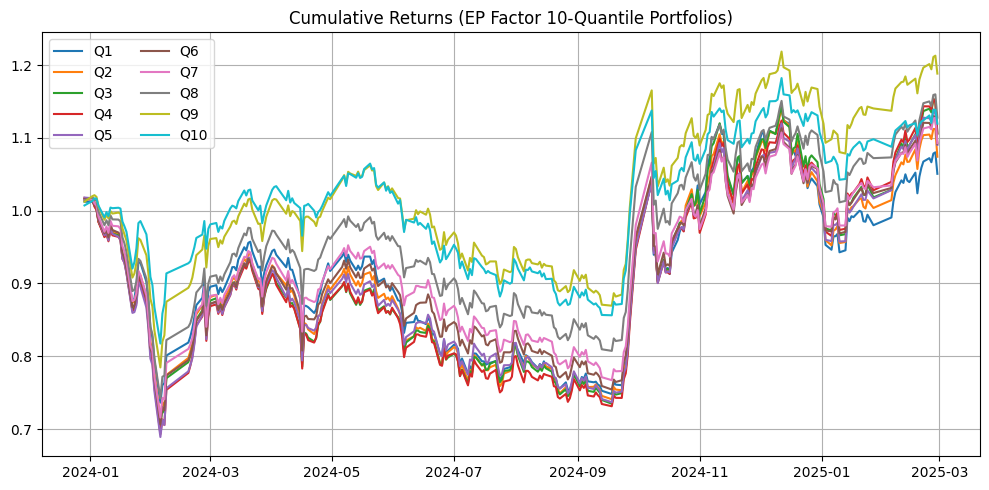

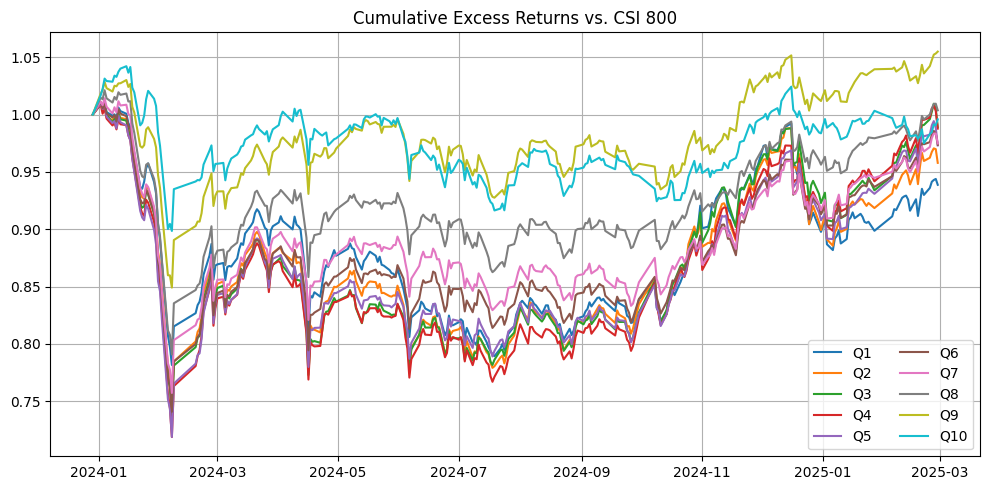

In [17]:
plt.figure(figsize=(10, 5))
for col in cum_ret.columns:
    plt.plot(cum_ret.index, cum_ret[col], label=col)
plt.title("Cumulative Returns (EP Factor 10-Quantile Portfolios)")
plt.legend(ncol=2)
plt.tight_layout()
plt.grid(True)
plt.savefig(IMG1, dpi=150)

plt.figure(figsize=(10, 5))
for col in excess_cum.columns:
    plt.plot(excess_cum.index, excess_cum[col], label=col)
plt.title("Cumulative Excess Returns vs. CSI 800")
plt.legend(ncol=2)
plt.tight_layout()
plt.grid(True)
plt.savefig(IMG2, dpi=150)

# ===========================
html_tpl = Template(dedent("""
<!DOCTYPE html>
<html lang="zh-CN">
<head>
    <meta charset="utf-8">
    <title>EP 因子测试报告</title>
    <style>
        body{font-family:Arial,Helvetica,sans-serif;margin:40px;}
        table{border-collapse:collapse;width:60%;margin-bottom:30px;}
        th,td{border:1px solid #888;padding:6px;text-align:center;}
    </style>
</head>
<body>
<h1>EP 单因子月度选股回测报告</h1>

<h2>1. 夏普率 (年化)</h2>
<table>
<thead><tr><th>组合</th>{% for c in sharpe.index %}<th>{{c}}</th>{% endfor %}</tr></thead>
<tbody><tr><td>Sharpe</td>{% for v in sharpe.values %}<td>{{"%.2f"|format(v)}}</td>{% endfor %}</tr></tbody>
</table>

<h2>2. 因子 IC (Spearman, 月度)</h2>
<table>
<thead><tr><th>月份</th>{% for c in ic_series.index %}<th>{{c}}</th>{% endfor %}</tr></thead>
<tbody><tr><td>IC</td>{% for v in ic_series.values %}<td>{{"%.2f"|format(v)}}</td>{% endfor %}</tr></tbody>
</table>                           
<p>平均&nbsp;IC&nbsp;={{"%.3f"|format(ic_mean)}}，IC IR={{"%.3f"|format(ic_ir)}}</p>

<h2>3. 累计收益曲线</h2>
<img src="{{img1}}" width="800">

<h2>4. 累计超额收益曲线</h2>
<img src="{{img2}}" width="800">

<small>生成日期：{{today}}</small>
</body>
</html>
"""))

# ic_series = pd.Series(ic_list).dropna()
html_out = html_tpl.render(
    sharpe=sharpe.round(3),
    ic_series=ic_series.round(3),
    ic_mean=ic_series.mean(),
    ic_ir=ic_series.mean() / ic_series.std(ddof=1),
    img1=IMG1,
    img2=IMG2,
    today=datetime.today().strftime("%Y-%m-%d")
)

with open(REPORT_HTML, "w", encoding="utf-8") as f:
    f.write(html_out)

print("已完成报告文件：", REPORT_HTML)
